In [134]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#plt.style.use('bmh')

np.random.seed(sum(map(ord, "distributions")))


In [2]:
cwd = os.getcwd()
cwd

'C:\\Users\\Renato Aranha\\Documents\\Mestrado\\Foundation_of_DS\\CartolaFCDados'

In [3]:
atletas_all_years = pd.DataFrame()
clubes_all_years = pd.DataFrame()
partidas_all_years = pd.DataFrame()
posicoes_all_years = pd.DataFrame()
scouts_all_years = pd.DataFrame()
status_all_years = pd.DataFrame()


for i in range(2014, 2018):
    
    path_atl = os.path.join(cwd, str(i)+"\\Atletas.csv")    
    path_club = os.path.join(cwd, str(i)+"\\Clubes.csv")    
    path_part = os.path.join(cwd, str(i)+"\\Partidas.csv")    
    path_pos = os.path.join(cwd, str(i)+"\\Posicoes.csv")   
    path_sct = os.path.join(cwd, str(i)+"\\Scouts.csv")    
    path_stts = os.path.join(cwd, str(i)+"\\Status.csv")
    
    atletas = pd.read_csv(path_atl)
    atletas['Ano'] = i
    clubes = pd.read_csv(path_club)
    #clubes['Ano'] = i
    partidas = pd.read_csv(path_part)
    partidas['Ano'] = i
    posicoes = pd.read_csv(path_pos)
    #posicoes['Ano'] = i
    scouts = pd.read_csv(path_sct)
    scouts['Ano'] = i
    status = pd.read_csv(path_stts)
    #status['Ano'] = i
    
    atletas_all_years = atletas_all_years.append(atletas)
    clubes_all_years = clubes_all_years.append(clubes).drop_duplicates()
    partidas_all_years = partidas_all_years.append(partidas)
    posicoes_all_years = posicoes_all_years.append(posicoes).drop_duplicates()
    scouts_all_years = scouts_all_years.append(scouts)
    status_all_years = status_all_years.append(status).drop_duplicates()

# Gerando tabela com partidas

In [4]:
partidas_all_years.head()

,Ano,CasaID,ID,PlacarCasa,PlacarVisitante,Resultado,Rodada,VisitanteID
0,2014,262,179872,0.0,0.0,Empate,1,290
1,2014,266,179873,3.0,0.0,Casa,1,316
2,2014,276,179874,3.0,0.0,Casa,1,263
3,2014,277,179875,1.0,1.0,Empate,1,292
4,2014,293,179876,1.0,0.0,Casa,1,284


In [5]:
clubes_all_years.head()

,ID,Nome,Abreviacao,Slug
0,262,Flamengo,FLA,flamengo
1,263,Botafogo,BOT,botafogo
2,264,Corinthians,COR,corinthians
3,265,Bahia,BAH,bahia
4,266,Fluminense,FLU,fluminense


In [6]:
def gera_partidas_com_clubes(partidas_all_years, clubes_all_years):
    partidas_all_years = partidas_all_years.merge(clubes_all_years[['ID','Abreviacao']], how='inner', left_on='CasaID',\
                         right_on='ID')
    partidas_all_years = partidas_all_years.merge(clubes_all_years[['ID','Abreviacao']], how='inner', left_on='VisitanteID',\
                         right_on='ID')
    partidas_all_years = partidas_all_years.drop(labels=['ID_y','ID'], axis = 1)
    partidas_com_clubes = partidas_all_years.rename(columns={'ID_x':'ID_partida','Abreviacao_x':'abrev_clube_casa','Abreviacao_y':'abrev_clube_fora'})
    return partidas_com_clubes

def remove_erros_SPO(partidas_com_clubes):
    a = partidas_com_clubes.copy().drop_duplicates()
    temp = pd.DataFrame(a.groupby(['ID_partida'])['ID_partida'].count())
    temp2 = temp[temp.ID_partida == 2]
    
    a = a[(a.ID_partida.isin(temp2.index))]
    a = a[(a.abrev_clube_casa == 'SPO') | (a.abrev_clube_fora == 'SPO')]
    
    final = partidas_com_clubes[~partidas_com_clubes.index.isin(a.index)]
    partidas_com_clubes_corrigido = final.drop_duplicates()
    
    return partidas_com_clubes_corrigido

def adiciona_pontuacao(partidas_com_clubes_corrigido):
    def pts_casa(casa, fora):
        if casa > fora:
            a = 3
        elif casa < fora:
            a = 0
        else:
            a = 1
        return a

    def pts_fora(casa, fora):
        if casa > fora:
            a = 0
        elif casa < fora:
            a = 3
        else:
            a = 1
        return a
    
    a = partidas_com_clubes_corrigido.copy().drop_duplicates().reset_index()
    a['pts_casa'] = a.apply(lambda x: pts_casa(x.PlacarCasa, x.PlacarVisitante), axis=1)
    a['pts_fora'] = a.apply(lambda x: pts_fora(x.PlacarCasa, x.PlacarVisitante), axis=1)
    
    partidas_com_pontuacao = a
    
    return partidas_com_pontuacao

def gera_classificacao(partidas_com_pontuacao):
    b = partidas_com_pontuacao.copy()
    casa = pd.DataFrame(b.groupby(['Ano','abrev_clube_casa'])['pts_casa'].sum())
    fora = pd.DataFrame(b.groupby(['Ano','abrev_clube_fora'])['pts_fora'].sum())
    tabela = pd.concat([casa, fora], axis=1)
    tabela['pts_total'] = tabela.pts_casa + tabela.pts_fora
    tabela = tabela.reset_index().sort_values(by=['Ano','pts_total'], ascending = [True, False])
    return tabela

In [7]:
partidas_com_clubes = gera_partidas_com_clubes(partidas_all_years, clubes_all_years).drop_duplicates()

partidas_com_clubes_corrigido = remove_erros_SPO(partidas_com_clubes)

partidas_com_pontuacao = adiciona_pontuacao(partidas_com_clubes_corrigido)

tabela = gera_classificacao(partidas_com_pontuacao)

tabela

,Ano,abrev_clube_casa,pts_casa,pts_fora,pts_total
8,2014,CRU,47,33,80
17,2014,SAO,39,31,70
6,2014,COR,42,27,69
14,2014,INT,45,24,69
2,2014,CAM,41,21,62
11,2014,FLU,39,22,61
13,2014,GRE,40,21,61
3,2014,CAP,35,19,54
16,2014,SAN,33,20,53
10,2014,FLA,35,17,52


In [8]:
partidas_com_clubes_corrigido

,Ano,CasaID,ID_partida,PlacarCasa,PlacarVisitante,Resultado,Rodada,VisitanteID,abrev_clube_casa,abrev_clube_fora
0,2014,262,179872,0.0,0.0,Empate,1,290,FLA,GOI
2,2015,262,190387,4.0,1.0,Casa,34,290,FLA,GOI
4,2014,266,180066,2.0,0.0,Casa,13,290,FLU,GOI
6,2015,266,190326,2.0,0.0,Casa,28,290,FLU,GOI
8,2014,276,180145,3.0,0.0,Casa,31,290,SAO,GOI
10,2015,276,190233,0.0,3.0,Visitante,19,290,SAO,GOI
12,2014,277,179998,2.0,0.0,Casa,25,290,SAN,GOI
14,2015,277,190355,3.0,1.0,Casa,31,290,SAN,GOI
16,2014,293,180179,1.0,0.0,Casa,37,290,CAP,GOI
18,2015,293,190261,3.0,0.0,Casa,21,290,CAP,GOI


In [9]:
partidas_com_clubes_corrigido.to_csv('partidas_all_years.csv', sep='\t')

# Gerando tabela com atletas

In [10]:
atletas_all_years.head()

,ID,Apelido,ClubeID,PosicaoID,Ano
0,80583,Lucas Lima,277,4,2014
1,72079,Bruno Cortez,288,2,2014
2,86189,Mosquito,293,5,2014
3,68938,Giovanni Augusto,316,4,2014
4,68974,Marcão,316,5,2014


In [11]:
clubes_all_years.head()

,ID,Nome,Abreviacao,Slug
0,262,Flamengo,FLA,flamengo
1,263,Botafogo,BOT,botafogo
2,264,Corinthians,COR,corinthians
3,265,Bahia,BAH,bahia
4,266,Fluminense,FLU,fluminense


In [12]:
posicoes_all_years

,ID,Nome,Abreviacao
0,1,Goleiro,GOL
1,2,Lateral,LAT
2,3,Zagueiro,ZAG
3,4,Meia,MEI
4,5,Atacante,ATA
5,6,Técnico,TEC


In [13]:
atletas_all_years = atletas_all_years.merge(clubes_all_years[['ID','Abreviacao','Nome']], how='inner', left_on='ClubeID',\
                         right_on='ID')

atletas_all_years = atletas_all_years.merge(posicoes_all_years[['ID','Abreviacao']], how='inner', left_on='PosicaoID',\
                         right_on='ID')

atletas_all_years = atletas_all_years.drop(labels=['ID_y','ID'], axis = 1)

In [14]:
atletas_all_years = atletas_all_years.rename(columns={'ID_x':'ID_jogador','Nome':'nome_clube','Abreviacao_x':'abrev_clube',\
                                                     'Abreviacao_y':'posicao'})

In [15]:
atletas_all_years.head()

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
0,80583,Lucas Lima,277,4,2014,SAN,Santos,MEI
1,80583,Lucas Lima,277,4,2014,SAN,Santos,MEI
2,88002,Serginho,277,4,2014,SAN,Santos,MEI
3,88002,Serginho,277,4,2014,SAN,Santos,MEI
4,70132,Alan Santos,277,4,2014,SAN,Santos,MEI


In [16]:
atletas_all_years = atletas_all_years.drop_duplicates()

In [17]:
atletas_all_years.to_csv('atletas_all_years.csv', sep='\t')

In [18]:
scouts_all_years.head()

,Rodada,ClubeID,AtletaID,Participou,Pontos,PontosMedia,Preco,PrecoVariacao,FS,PE,...,RB,FC,GC,CA,CV,SG,DD,DP,GS,Ano
0,0,285.0,36443,False,0.0,0.00,9.00,0.00,0,0,...,0,0,0,0,0,0,0,0,0,2014
1,1,285.0,36443,True,5.0,5.00,10.60,1.60,0,0,...,0,0,0,0,0,1,0,0,0,2014
2,2,285.0,36443,True,-3.0,1.00,8.27,-2.33,2,0,...,0,0,0,0,0,0,0,0,2,2014
3,3,285.0,36443,True,-2.6,-0.20,6.81,-1.46,0,2,...,0,0,0,0,0,0,0,0,1,2014
4,4,285.0,36443,True,4.0,0.85,7.96,1.15,0,0,...,0,0,0,0,0,0,2,0,1,2014


In [19]:
atletas_all_years[atletas_all_years.PosicaoID == 6].sort_values('ID_jogador')

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
4931,36856,Celso Roth,294,6,2014,CFC,Coritiba,TEC
5191,36856,Celso Roth,267,6,2015,VAS,Vasco,TEC
5109,36856,Celso Roth,285,6,2016,INT,Internacional,TEC
5141,36934,Muricy Ramalho,262,6,2016,FLA,Flamengo,TEC
5007,36934,Muricy Ramalho,276,6,2014,SAO,São Paulo,TEC
5157,36940,Oswaldo de Oliveira,264,6,2016,COR,Corinthians,TEC
5182,36940,Oswaldo de Oliveira,282,6,2017,CAM,Atlético-MG,TEC
5133,36940,Oswaldo De Oliveira,262,6,2015,FLA,Flamengo,TEC
5053,36940,Oswaldo De Oliveira,275,6,2015,PAL,Palmeiras,TEC
4871,36940,Oswaldo De Oliveira,277,6,2014,SAN,Santos,TEC


In [20]:
#GERANDO PONTUAÇÃO DOS CLUBES RODADA A RODADA

treinadores = atletas_all_years.ID_jogador[atletas_all_years.PosicaoID == 6]

cols1 = ['Ano','Rodada', 'ClubeID', 'AtletaID', 'Participou', 'Pontos']
tabela_cartola = scouts_all_years[scouts_all_years.AtletaID.isin(treinadores)][cols1]

cols2 = ['Ano','Rodada', 'ClubeID', 'AtletaID', 'Participou', 'Pontos', 'Abreviacao']
tabela_cartola = tabela_cartola.merge(clubes_all_years[['ID','Abreviacao','Nome']], how='inner', left_on='ClubeID',\
                         right_on='ID')[cols2]

cols3 = ['Ano','Rodada', 'ClubeID', 'AtletaID', 'Apelido','Participou', 'Pontos', 'Abreviacao']
tabela_cartola = tabela_cartola.merge(atletas_all_years[['ID_jogador','Apelido']], how='inner', left_on='AtletaID',\
                         right_on='ID_jogador')[cols3]

tabela_cartola = tabela_cartola.sort_values(by=['Ano', 'ClubeID', 'Rodada'])

tabela_cartola['Apelido'] = tabela_cartola.apply(lambda x: str(x.Apelido).lower(), axis=1)

tabela_cartola = tabela_cartola.drop_duplicates()

tabela_cartola

,Ano,Rodada,ClubeID,AtletaID,Apelido,Participou,Pontos,Abreviacao
16913,2014,0,262,79019,jayme de almeida,False,0.00,FLA
16919,2014,1,262,79019,jayme de almeida,True,2.35,FLA
16925,2014,2,262,79019,jayme de almeida,True,1.59,FLA
16931,2014,3,262,79019,jayme de almeida,True,5.79,FLA
16937,2014,4,262,79019,jayme de almeida,True,0.16,FLA
16143,2014,11,262,41327,vanderlei luxemburgo,False,0.00,FLA
16153,2014,12,262,41327,vanderlei luxemburgo,True,4.39,FLA
16163,2014,13,262,41327,vanderlei luxemburgo,True,1.65,FLA
16173,2014,14,262,41327,vanderlei luxemburgo,True,4.30,FLA
16183,2014,15,262,41327,vanderlei luxemburgo,True,3.87,FLA


In [21]:
tabela_quase_final = pd.DataFrame(tabela_cartola.groupby(['Ano','Abreviacao'])['Pontos'].median())
tabela_final = tabela_quase_final.reset_index().sort_values(by=['Ano','Pontos'], ascending = [True, False])
tabela_final

,Ano,Abreviacao,Pontos
8,2014,CRU,3.790
6,2014,COR,3.650
14,2014,INT,3.550
12,2014,GOI,3.495
16,2014,SAN,3.450
17,2014,SAO,3.440
13,2014,GRE,3.330
10,2014,FLA,3.260
2,2014,CAM,3.155
11,2014,FLU,2.860


In [22]:
tabela

,Ano,abrev_clube_casa,pts_casa,pts_fora,pts_total
8,2014,CRU,47,33,80
17,2014,SAO,39,31,70
6,2014,COR,42,27,69
14,2014,INT,45,24,69
2,2014,CAM,41,21,62
11,2014,FLU,39,22,61
13,2014,GRE,40,21,61
3,2014,CAP,35,19,54
16,2014,SAN,33,20,53
10,2014,FLA,35,17,52


In [23]:
cols_final = ['Ano', 'Abreviacao', 'pts_total', 'Pontos']
tabela_unificada = tabela.merge(tabela_final, how = 'inner', left_on = ['Ano','abrev_clube_casa'], right_on=['Ano','Abreviacao'])[cols_final]
tabela_unificada = tabela_unificada.rename(columns={'pts_total':'pts_real','Pontos':'pts_cartola'})
tabela_unificada

,Ano,Abreviacao,pts_real,pts_cartola
0,2014,CRU,80,3.790
1,2014,SAO,70,3.440
2,2014,COR,69,3.650
3,2014,INT,69,3.550
4,2014,CAM,62,3.155
5,2014,FLU,61,2.860
6,2014,GRE,61,3.330
7,2014,CAP,54,2.215
8,2014,SAN,53,3.450
9,2014,FLA,52,3.260


In [24]:
tabela_unificada['rank'] = np.where(tabela_unificada['Ano']==2014, [i+1 for i in range(0,len(tabela_unificada))], '')
tabela_unificada

,Ano,Abreviacao,pts_real,pts_cartola,rank
0,2014,CRU,80,3.790,1
1,2014,SAO,70,3.440,2
2,2014,COR,69,3.650,3
3,2014,INT,69,3.550,4
4,2014,CAM,62,3.155,5
5,2014,FLU,61,2.860,6
6,2014,GRE,61,3.330,7
7,2014,CAP,54,2.215,8
8,2014,SAN,53,3.450,9
9,2014,FLA,52,3.260,10


In [171]:
#tabela_unificada = tabela_unificada.sort_values(by=['Ano','pts_cartola'], ascending=[True, False])
#tabela_unificada['rank_cartola'] = np.where(tabela_unificada['Ano']==2014, [i+1 for i in range(0, len(tabela_unificada))], '')
#tabela_unificada = tabela_unificada.sort_values(by=['Ano','pts_real'], ascending=[True, False])
tabela_unificada.Abreviacao[tabela_unificada['Ano'] == 2014]

0     CRU
1     SAO
2     COR
3     INT
4     CAM
6     GRE
5     FLU
7     CAP
8     SAN
9     FLA
10    SPT
13    GOI
11    CFC
12    FIG
14    CHA
15    PAL
16    VIT
17    BAH
18    BOT
19    CRI
Name: Abreviacao, dtype: object

In [29]:
tabela_unificada.to_csv('tabela_unificada.csv', sep='\t')

In [38]:
rank_real = tabela_unificada[tabela_unificada.Ano == 2014]['rank']
rank_cartola = tabela_unificada[tabela_unificada.Ano == 2014]['rank_cartola']

In [65]:
export = tabela_unificada[tabela_unificada.Ano == 2014][['Ano','rank','rank_cartola']]
#export.to_csv('export.csv', sep='\t')

In [66]:
data

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


In [76]:
export = export[['rank','rank_cartola','Ano']]
export

,rank,rank_cartola,Ano
0,1,1,2014
1,2,6,2014
2,3,2,2014
3,4,3,2014
4,5,9,2014
6,7,7,2014
5,6,10,2014
7,8,15,2014
8,9,5,2014
9,10,8,2014


In [78]:
export = export.astype(np.float)

In [106]:
export

,rank,rank_cartola,Ano
0,1.0,1.0,2014.0
1,2.0,6.0,2014.0
2,3.0,2.0,2014.0
3,4.0,3.0,2014.0
4,5.0,9.0,2014.0
6,7.0,7.0,2014.0
5,6.0,10.0,2014.0
7,8.0,15.0,2014.0
8,9.0,5.0,2014.0
9,10.0,8.0,2014.0


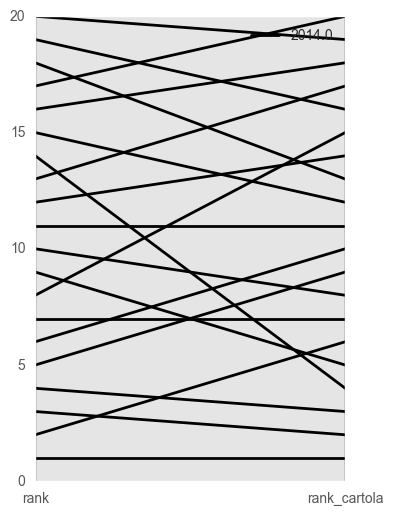

In [105]:
# libraries
import pandas
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
from pandas.tools.plotting import parallel_coordinates
 
data = sns.load_dataset('iris')
 
# Make the plot
plt.figure(figsize=(4,6))
parallel_coordinates(export, 'Ano', colormap='cubehelix')
plt.show()

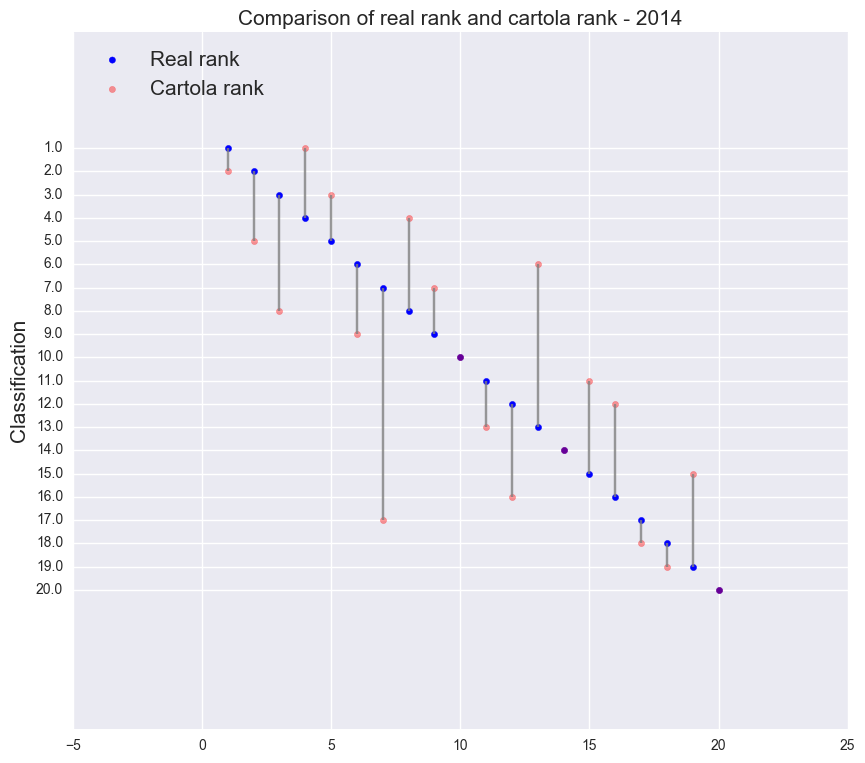

In [218]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt

# Create a dataframe
value1=np.random.uniform(size=20)
value2=value1+np.random.uniform(size=20)/4
#df = pd.DataFrame({'group':list(map(chr, range(65, 85))), 'value1':value1 , 'value2':value2 })
df = pd.DataFrame({'group':list(map(chr, range(65, 85))), 'rank':export['rank'] , 'rank_cartola':export['rank_cartola'] })

# Reorder it following the values of the first value:
ordered_df = df.sort_values(by='rank', ascending = False)
my_range=range(1,len(df.index)+1)
 
# The vertical plot is made using the hline function
# I load the saeaborn library only to benefit the nice looking feature
import seaborn as sns
fig_size[0], fig_size[1] = 10, 9

labels = tabela_unificada.Abreviacao[tabela_unificada['Ano'] == 2014]

'''for label, x, y in zip(labels, export['rank'], export['rank_cartola']):
    plt.annotate(
        label,
        xy=(x, y), 
        xytext=(-20, 20),
        textcoords='offset points', ha='left', va='top',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.2),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))'''
    
plt.vlines(x=my_range, ymin=ordered_df['rank'], ymax=ordered_df['rank_cartola'], color='grey', alpha=0.8)
plt.scatter( my_range, ordered_df['rank'], color='blue', alpha=1, label='Real rank')
plt.scatter( my_range, ordered_df['rank_cartola'], color='red', alpha=0.4 , label='Cartola rank')
plt.rcParams["figure.figsize"] = fig_size
plt.legend(loc=2, fontsize = 15)
 
# Add title and axis names
plt.yticks(my_range, ordered_df['rank'])
#plt.xticks(my_range, ordered_df['rank'])
plt.title("Comparison of real rank and cartola rank - 2014", loc='center', fontsize = 15)
plt.ylabel('Classification', fontsize = 15)
#plt.xlabel('Group')

# Exploratory Data Analysis

In [31]:
atletas_all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7690 entries, 0 to 7689
Data columns (total 8 columns):
ID_jogador     7690 non-null int64
Apelido        7690 non-null object
ClubeID        7690 non-null int64
PosicaoID      7690 non-null int64
Ano            7690 non-null int64
abrev_clube    7690 non-null object
nome_clube     7690 non-null object
posicao        7690 non-null object
dtypes: int64(4), object(4)
memory usage: 540.7+ KB


In [21]:
partidas_all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5124 entries, 0 to 5123
Data columns (total 10 columns):
Ano                 5124 non-null int64
CasaID              5124 non-null int64
ID_partida          5124 non-null int64
PlacarCasa          5120 non-null float64
PlacarVisitante     5120 non-null float64
Resultado           3892 non-null object
Rodada              5124 non-null int64
VisitanteID         5124 non-null int64
abrev_clube_casa    5124 non-null object
abrev_clube_fora    5124 non-null object
dtypes: float64(2), int64(5), object(3)
memory usage: 440.3+ KB


In [28]:
atletas_all_years.head()

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
0,80583,Lucas Lima,277,4,2014,SAN,Santos,MEI
2,88002,Serginho,277,4,2014,SAN,Santos,MEI
4,70132,Alan Santos,277,4,2014,SAN,Santos,MEI
6,78235,Leandrinho,277,4,2014,SAN,Santos,MEI
8,89637,Thiago Maia,277,4,2014,SAN,Santos,MEI


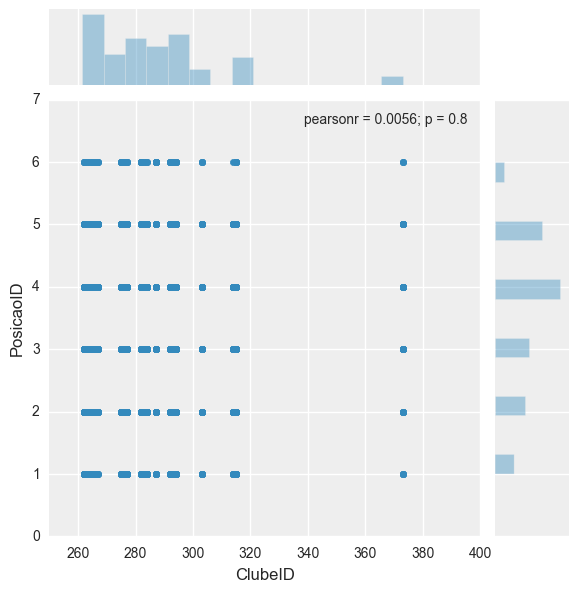

In [88]:
sns.jointplot(x="ClubeID", y="PosicaoID", data=atletas_all_years[atletas_all_years.Ano == 2017], size=6, xlim=[250,400]);

In [89]:
list(set(atletas_all_years.dtypes.tolist()))

[dtype('int64'), dtype('O')]

In [90]:
df_num = atletas_all_years.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,ID_jogador,ClubeID,PosicaoID,Ano
0,80583,277,4,2014
1,80583,277,4,2014
2,88002,277,4,2014
3,88002,277,4,2014
4,70132,277,4,2014


In [27]:
atletas_all_years.head()

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
0,80583,Lucas Lima,277,4,2014,SAN,Santos,MEI
2,88002,Serginho,277,4,2014,SAN,Santos,MEI
4,70132,Alan Santos,277,4,2014,SAN,Santos,MEI
6,78235,Leandrinho,277,4,2014,SAN,Santos,MEI
8,89637,Thiago Maia,277,4,2014,SAN,Santos,MEI


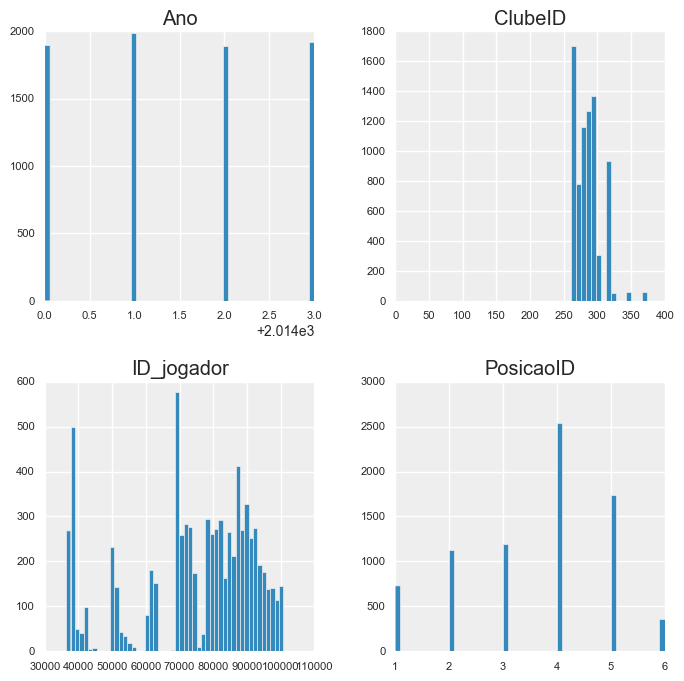

In [105]:
atletas_all_years.hist(figsize=(8, 8), bins=50, xlabelsize=8, ylabelsize=8);

In [104]:
atletas_all_years.sample(10).sort_values("ID_jogador")

,ID_jogador,Apelido,ClubeID,PosicaoID,Ano,abrev_clube,nome_clube,posicao
1413,38928,Dudu Cearense,263,4,2016,BOT,Botafogo,MEI
2436,41387,Eduardo Costa,314,4,2015,AVA,Avaí,MEI
5553,68928,Rafael,283,1,2017,CRU,Cruzeiro,GOL
5786,79066,Alex Muralha,262,1,2017,FLA,Flamengo,GOL
2348,82680,Nathan Índio,303,4,2015,PON,Ponte Preta,MEI
4400,86748,Breno,284,2,2014,GRE,Grêmio,LAT
2011,87226,Fabiano,264,4,2014,COR,Corinthians,MEI
2669,91866,Zé Ivaldo,293,3,2016,CAP,Atlético-PR,ZAG
7596,97454,Edinan,303,5,2017,PON,Ponte Preta,ATA
3423,98945,Derlan,266,3,2017,FLU,Fluminense,ZAG
